In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
#load data and preview data
df = pd.read_csv('https://bit.ly/2XZK7Bo')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# check shape
df.shape

(10000, 14)

In [4]:
#check for duplicates
df.duplicated().sum()

0

In [5]:
#check data types
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
#check for missing values
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
#handle missing values
df['Tenure'] = df.Tenure.fillna(value = df.Tenure.mean())

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
# drop RowNumber, Surname, CustomerId
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1)

In [9]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [10]:
#check the target
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [11]:
#check categorical data
print(df.Geography.value_counts())
print(df.Gender.value_counts())

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Male      5457
Female    4543
Name: Gender, dtype: int64


In [12]:
#check for imbalance
print(df[df['Exited'] == 1]['Exited'].count())
print(df[df['Exited'] == 0]['Exited'].count())

2037
7963


In [13]:
#encode categorical data
df_encoded = pd.get_dummies(df, columns = ['Geography', 'Gender'])

In [14]:
#preview encoded data
df_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [15]:
#split data
X = df_encoded.drop(['Exited'], axis=1)
Y = df_encoded['Exited']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)

In [16]:
#normalisation
scaler = StandardScaler()
features_to_normalize = ['CreditScore',	'Age',	'Tenure',	'Balance',	'NumOfProducts', 'EstimatedSalary']
scaler.fit(X_train[features_to_normalize])
X_train.loc[:,features_to_normalize] = scaler.transform(X_train[features_to_normalize])
X_test.loc[:,features_to_normalize] = scaler.transform(X_test[features_to_normalize])

In [17]:
def normal(features_train, target_train, features_test, target_test, model):
  model.fit(features_train, target_train)
  prediction = model.predict(features_test)

  print('F1:', f1_score(target_test, prediction))
  print('Accuracy: ', accuracy_score(prediction, target_test))

  probabilities = model.predict_proba(features_test)
  probabilities_one = probabilities[:, 1]
  auc_roc = roc_auc_score(target_test, probabilities_one)
  print('AUC-ROC:', auc_roc)

  return probabilities_one

In [18]:
def upsample(features_train, target_train, repeat, model, features_test, target_test):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    model.fit(features_upsampled, target_upsampled)
    model_prediction = model.predict(features_test)

    print('F1:', f1_score(target_test, model_prediction))
    print('Accuracy: ', accuracy_score(model_prediction, target_test))

    upsampled_probabilities = model.predict_proba(features_test)
    upsampled_probabilities_one = upsampled_probabilities[:, 1]
    upsampled_auc_roc = roc_auc_score(target_test, upsampled_probabilities_one)
    print('AUC-ROC:', upsampled_auc_roc)

    return upsampled_probabilities_one

In [19]:
def downsample(features_train, target_train, fraction, model, features_test, target_test):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    model.fit(features_downsampled, target_downsampled)
    downsampled_prediction = model.predict(features_test)
    print('F1:', f1_score(target_test, downsampled_prediction))
    print('Accuracy: ', accuracy_score(downsampled_prediction, target_test))

    downsampled_probabilities = log_model_downsampled.predict_proba(features_test)
    downsampled_probabilities_one = downsampled_probabilities[:, 1]
    downsampled_auc_roc = roc_auc_score(target_test, downsampled_probabilities_one)
    print('AUC-ROC:', downsampled_auc_roc)

    return downsampled_probabilities_one

In [20]:
#normal model
log_model = LogisticRegression(random_state=12345, solver='liblinear')
log_prob_one_test = normal(X_train, Y_train, X_test, Y_test, log_model)

F1: 0.3298245614035088
Accuracy:  0.809
AUC-ROC: 0.7716057122953673


In [21]:
# adjust class weight
log_model_balanced = LogisticRegression(
    random_state=12345, class_weight='balanced', solver='liblinear'
)
log_balanced_prob_one = normal(X_train, Y_train, X_test, Y_test, log_model)

F1: 0.3298245614035088
Accuracy:  0.809
AUC-ROC: 0.7716057122953673


In [22]:
#upsampled model
log_model_upsampled = LogisticRegression(random_state=12345, solver='liblinear')
log_upsamp_prob_one_test = upsample(X_train, Y_train, 10, log_model_upsampled, X_test, Y_test)

F1: 0.41228070175438597
Accuracy:  0.464
AUC-ROC: 0.7742745462285693


In [23]:
# Adjust Class Weight
log_upsampled_and_balanced = LogisticRegression(
    random_state=12345, class_weight='balanced', solver='liblinear'
)
log_upsamp_balanced_prob_one = upsample(X_train, Y_train, 10, log_upsampled_and_balanced, X_test, Y_test)

F1: 0.4932432432432433
Accuracy:  0.7
AUC-ROC: 0.7740206664344595


In [24]:
#downsampled model
log_model_downsampled = LogisticRegression(random_state=12345, solver='liblinear')
log_downsamp_prob_one_test = downsample(X_train, Y_train, 0.1, log_model_downsampled, X_test, Y_test)

F1: 0.41154055525313016
Accuracy:  0.4595
AUC-ROC: 0.7751817020782538


In [25]:
# Adjust Class Weight
log_downsampled_and_balanced = LogisticRegression(
    random_state=12345, class_weight='balanced', solver='liblinear'
)
log_downsamp_balanced_prob_one = downsample(X_train, Y_train, 0.1, log_downsampled_and_balanced, X_test, Y_test)

F1: 0.49575551782682514
Accuracy:  0.703
AUC-ROC: 0.7751817020782538


In [26]:
#find optimal parameters
rf = RandomForestClassifier(random_state = 12345)
rf_params = {'max_depth' : range(1,15), 'n_estimators' : range(1,50)}
rf_optimal = GridSearchCV(rf, rf_params).fit(X_train, Y_train)
print(rf_optimal.best_estimator_)

RandomForestClassifier(max_depth=12, n_estimators=34, random_state=12345)


In [27]:
#normal model
rf_model = RandomForestClassifier(max_depth=12, n_estimators=34, random_state=12345)
rf_probabilities_one_test = normal(X_train, Y_train, X_test, Y_test, rf_model)

F1: 0.6270430906389303
Accuracy:  0.8745
AUC-ROC: 0.8646549789078525


In [28]:
# adjust class weight
rf_model_balanced = RandomForestClassifier(
    max_depth=12, n_estimators=34, random_state=12345, class_weight='balanced'
)

rf_balanced_prob_one = normal(X_train, Y_train, X_test, Y_test, rf_model_balanced)

F1: 0.6117353308364545
Accuracy:  0.8445
AUC-ROC: 0.8584558225937537


In [29]:
rf_upsampled = RandomForestClassifier(max_depth=12, n_estimators=34, random_state=12345)
rf_upsamp_probabilities_one_test = upsample(X_train, Y_train, 10, rf_upsampled, X_test, Y_test)

F1: 0.5760869565217391
Accuracy:  0.766
AUC-ROC: 0.853807809899764


In [30]:
# adjust class weight
rf_upsampled_and_balanced = RandomForestClassifier(
    max_depth=12, n_estimators=34, random_state=12345, class_weight='balanced'
)

rf_upsamp_balanced_prob_one = upsample(X_train, Y_train, 10, rf_upsampled_and_balanced, X_test, Y_test)

F1: 0.6026200873362445
Accuracy:  0.818
AUC-ROC: 0.8679058787104764


In [31]:
rf_downsampled = RandomForestClassifier(max_depth=12, n_estimators=34, random_state=12345)
rf_downsamp_probabilities_one_test = downsample(X_train, Y_train, 0.1, rf_downsampled, X_test, Y_test)

F1: 0.4611650485436893
Accuracy:  0.556
AUC-ROC: 0.7751817020782538


In [32]:
# adjust class weight
rf_downsampled_and_balanced = RandomForestClassifier(
    max_depth=12, n_estimators=34, random_state=12345, class_weight='balanced'
)

rf_downsamp_balanced_prob_one = downsample(X_train, Y_train, 0.1, rf_downsampled_and_balanced, X_test, Y_test)

F1: 0.47795527156549517
Accuracy:  0.5915
AUC-ROC: 0.7751817020782538


In [33]:
#find optimal parameters
dt = DecisionTreeClassifier(random_state = 12345)
dt_params = {'max_depth' : range(1,15)}
dt_optimal = GridSearchCV(dt, dt_params).fit(X_train, Y_train)
print(dt_optimal.best_estimator_)

DecisionTreeClassifier(max_depth=6, random_state=12345)


In [34]:
dt_model = DecisionTreeClassifier(max_depth=6, random_state=12345)
dt_probabilities_one_test = normal(X_train, Y_train, X_test, Y_test, dt_model)

F1: 0.5961251862891207
Accuracy:  0.8645
AUC-ROC: 0.8480413328689191


In [35]:
# adjust class weight
dt_model_balanced = DecisionTreeClassifier(
    max_depth=6, random_state=12345, class_weight='balanced'
)

dt_balanced_prob_one = normal(X_train, Y_train, X_test, Y_test, dt_model_balanced)

F1: 0.568100358422939
Accuracy:  0.759
AUC-ROC: 0.8418220519369944


In [36]:
dt_upsampled = DecisionTreeClassifier(max_depth=6, random_state=12345)
dt_upsamp_probabilities_one_test = upsample(X_train, Y_train, 10, dt_upsampled, X_test, Y_test)

F1: 0.5232815964523282
Accuracy:  0.6775
AUC-ROC: 0.8470838654746701


In [37]:
# adjust class weight
dt_upsampled_and_balanced = DecisionTreeClassifier(
    max_depth=6, random_state=12345, class_weight='balanced'
)

dt_upsamp_balanced_prob_one = upsample(X_train, Y_train, 10, dt_upsampled_and_balanced, X_test, Y_test)

F1: 0.568100358422939
Accuracy:  0.759
AUC-ROC: 0.8417887689152057


In [38]:
dt_downsampled = DecisionTreeClassifier(max_depth=6, random_state=12345)
dt_downsamp_probabilities_one_test = downsample(X_train, Y_train, 0.1, dt_downsampled, X_test, Y_test)

F1: 0.45562130177514787
Accuracy:  0.54
AUC-ROC: 0.7751817020782538


In [39]:
# adjust class weight
dt_downsampled_and_balanced = DecisionTreeClassifier(
    max_depth=6, random_state=12345, class_weight='balanced'
)

dt_downsamp_balanced_prob_one = downsample(X_train, Y_train, 0.1, dt_downsampled_and_balanced, X_test, Y_test)

F1: 0.5632183908045978
Accuracy:  0.772
AUC-ROC: 0.7751817020782538


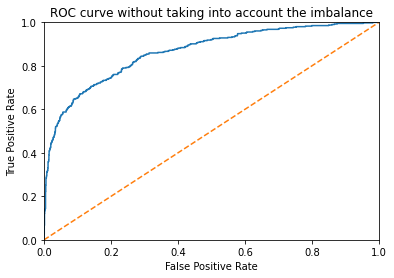

In [40]:
#without taking into account the imbalance
fpr, tpr, thresholds = roc_curve(Y_test, rf_probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve without taking into account the imbalance')
plt.show()

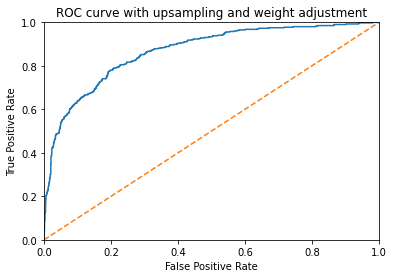

In [41]:
#with upsampling
fpr, tpr, thresholds = roc_curve(Y_test, rf_upsamp_balanced_prob_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with upsampling and weight adjustment')
plt.show()